(v4_announcement)=

# PyMC 4.0 Release Announcement
:::{post} June 6, 2022
:tags: release, aesara, jax
:category: news
:author: Thomas Wiecki
:::

We, the PyMC core development team, are incredibly excited to announce the release of a major rewrite of PyMC3 (now called just PyMC): `4.0`. Internally, we have already been using PyMC 4.0 almost exclusively for many months and found it to be very stable and better in every aspect. Every user should upgrade, as there are many exciting new updates that we will talk about in this and upcoming blog posts.

:::{figure-md} versions_diagram

![Diagram of the PyMC version history](pymc_versions.png)

Graphic by [Ravin Kumar](https://twitter.com/canyon289)

:::

## Full API compatibility for model building
To get the main question out of the way: Yes, you can just keep your existing PyMC modeling code without having to change anything (in most cases) and get all the improvements for free. The only thing most users will have to change is the import from `import pymc3 as pm` to `import pymc as pm`. For more information, see the [quick migration guide](https://www.pymc-labs.io/blog-posts/the-quickest-migration-guide-ever-from-pymc3-to-pymc-v40/). If you are using more advanced features of PyMC beyond the modeling API, you might have to change some things.

## It's now called PyMC instead of PyMC3
First, the biggest news: **PyMC3 has been renamed to PyMC. PyMC3 version 3.x will stay under the current name to not break production systems but future versions will use the PyMC name everywhere.** While there were a few reasons for this, the main one is that PyMC3 4.0 looks quite confusing.

## Theano → Aesara
While evaluating other tensor libraries like `TensorFlow` and `PyTorch` as new backends we realized how amazing and unique `Theano` really was. It has a mature and hackable code base and a simple graph representation that allows easy graph manipulations, something that's very useful for probabilistic programming languages. In addition, `TensorFlow` and `PyTorch` focus on a dynamic graph which is useful for some things, but for a probabilistic programming package, a static graph is actually much better, and `Theano` is the only library that provided this.

So, we went ahead and forked the `Theano` library and undertook a massive cleaning up of the code-base (this charge was led by [Brandon Willard](https://twitter.com/brandontwillard)), removing swaths of old and obscure code, and restructuring the entire library to be more developer friendly.

This rewrite motivated renaming the package to [`Aesara`](https://github.com/aesara-devs/aesara) (Theano's daughter in Greek mythology). Quickly, a new developer team focused around improving `aesara` independent of `PyMC`.

## What's new in PyMC 4.0?

Alright, let's get to the good stuff. What makes PyMC 4.0 so awesome?

### New JAX backend for faster sampling

By far the most shiny new feature is the new JAX backend and the associated speed-ups. 

How does it work? `aesara` provides a representation of the model logp graph in form of various `aesara` `Ops` (operators) which represent the computations to be be performed. For example `exp(x + y)` would be an `Add` `Op` with two input arguments `x` and `y`. The result of the `Add` `Op` is then inputted into an `exp` `Op`.

This computation graph doesn't say anything about how we actually *execute* this graph, just what operations we want to perform. The functionality inherited from `theano` is to transpile this graph to C-code which would then get compiled, loaded into Python as a C-extension, and then could be executed very fast. But instead of transpiling the graph to C, `aesara` can now also target `JAX`.

This is very exciting, because `JAX` (through `XLA`) is capable of a whole bunch of low-level optimizations which lead to faster model evaluation, in addition to being able to run your PyMC model on the GPU.

Even more exciting is that this allows us to combine the `JAX` code that executes the PyMC model with a MCMC sampler also written in JAX. That way, the model evaluation *and* the sampler are one big JAX graph that gets optimized and executed without any Python call-overhead. We currently support a NUTS implementation provided by [`numpyro`](http://pyro.ai/numpyro/) as well as [`blackjax`](https://github.com/blackjax-devs/blackjax).

Early experiments and benchmarks show [impressive speed-ups](https://martiningram.github.io/mcmc-comparison/). Here is a small example of how much faster this is on a fairly small and simple model: the hierarchical linear regression of the famous Radon example.

In [ ]:
# Standard imports
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
np.set_printoptions(2)

import os, sys
sys.stderr = open(os.devnull, "w")

In order to do side-by-side comparisons, let's import both, the old `PyMC3` and `Theano` as well as the new `PyMC 4.0` and `Aesara`. For your own use-case, you will only need the new `pymc` packages of course.

In [3]:
# PyMC3 Imports
import pymc3 as pm3
import theano.tensor as tt
import theano

# PyMC 4.0 imports
import pymc as pm
import aesara.tensor as at 
import aesara

Load in the [radon dataset](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/) and preprocess it:

In [4]:
data = pd.read_csv(pm.get_data("radon.csv"))
county_names = data.county.unique()

data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
county_idx, counties = pd.factorize(data.county)
coords = {"county": counties, "obs_id": np.arange(len(county_idx))}

Next, let's define a hierarchical regression model inside of a function (see [this blog post](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/) for a description of this model). Note that we provide `pm`, our PyMC library, as an argument here. This is a bit unusual but allows us to create this model in `pymc3` or `pymc 4.0`, depending on which module we pass in. Here you can also see that most models that work in `pymc3` also work in `pymc 4.0` without any code change, you only need to change your imports.

In [5]:
def build_model(pm):
    with pm.Model(coords=coords) as hierarchical_model:
        # Intercepts, non-centered
        mu_a = pm.Normal("mu_a", mu=0.0, sigma=10)
        sigma_a = pm.HalfNormal("sigma_a", 1.0)
        a = pm.Normal("a", dims="county") * sigma_a + mu_a
        
        # Slopes, non-centered
        mu_b = pm.Normal("mu_b", mu=0.0, sigma=2.)
        sigma_b = pm.HalfNormal("sigma_b", 1.0)
        b = pm.Normal("b", dims="county") * sigma_b + mu_b
        
        eps = pm.HalfNormal("eps", 1.5)
        
        radon_est = a[county_idx] + b[county_idx] * data.floor.values
        
        radon_like = pm.Normal(
            "radon_like", mu=radon_est, sigma=eps, observed=data.log_radon, 
            dims="obs_id"
        )
        
    return hierarchical_model

Create and sample model in `pymc3`, nothing special:

In [6]:
model_pymc3 = build_model(pm3)

In [7]:
%%time
with model_pymc3:
    idata_pymc3 = pm3.sample(target_accept=0.9, return_inferencedata=True)

CPU times: user 1.8 s, sys: 229 ms, total: 2.03 s
Wall time: 21.5 s


Create and sample model in `pymc` 4.0, also nothing special (but note that `pm.sample()` now returns and `InferenceData` object by default):

In [8]:
model_pymc4 = build_model(pm)

In [9]:
%%time
with model_pymc4:
    idata_pymc4 = pm.sample(target_accept=0.9)

CPU times: user 4.08 s, sys: 315 ms, total: 4.39 s
Wall time: 16.9 s


Now, lets use a JAX sampler instead. Here we use the one provided by `numpyro`. These samplers live in a different submodule `sampling_jax` but the plan is to integrate them into `pymc.sample(backend="JAX")`.

In [10]:
import pymc.sampling_jax

In [11]:
%%time
with model_pymc4:
    idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9, progress_bar=False)

Compiling...
Compilation time =  0:00:00.648311
Sampling...
Sampling time =  0:00:04.195409
Transforming variables...
Transformation time =  0:00:00.025698
CPU times: user 7.51 s, sys: 108 ms, total: 7.62 s
Wall time: 5.01 s


That's a 3x speed-up -- for a single-line code change (although we've seen speed-ups much more impressive than that in the 20x range)! And this is just running things on the CPU, we can just as easily run this on the GPU where we saw even more impressive speed-ups (especially as we scale the data).

Again, for a more proper benchmark that also compares this to Stan, see [this blog post](https://martiningram.github.io/mcmc-comparison/).

#### The Future: Samplers written in `aesara`

While this current approach is already quite exciting, we can take this one step further. The setup we showed above takes the model logp graph (represented in `aesara`) and compiles it to `JAX`. The resulting `JAX` function we can then call from a sampler written in directly in `JAX` (i.e. `numpyro` or `blackjax`).

While lightning fast, this is suboptimal for two reasons:
1. For new backends, like `numba`, we would need to rewrite the sampler also in `numba`.
2. While we get low-level optimizations from `JAX` on the logp+sampler JAX-graph, we do not get any high-level optimizations, which is what `aesara` is great at, because `aesara` does not see the sampler.

With [`aehmc`](https://www.github.com/aesara-devs/aehmc) and [`aemcmc`](https://www.github.com/aesara-devs/aemcmc) the `aesara` devs are developing a library of samplers *written in `aesara`*. That way, our model logp, consisting out of `aesara` `Ops` can then be combined with the sampler logic, now also consisting out of `aesara` `Ops`, and form one big `aesara` graph.

On that big graph containing model *and* sampler, `aesara` can the do high-level optimizations to get a more efficient graph representation. In a next step it can then compile it to whatever backend we want: `JAX`, `numba`, `C`, or whatever other backend we add in the future.

If you think this is interesting, definitely check out these packages and consider contributing, this is where the next round of innovation will come from!

## Better integration into `aesara`

The next feature we are excited about is a better integration of `PyMC` into `aesara`.

In `PyMC3 3.x`, the random variables (RVs) created by e.g. calling `x = pm.Normal('x')` were not truly `theano` `Ops` so they did not integrate as nicely with the rest of `theano`. This created a lot of issues, limitations, and complexities in the library.

`Aesara` now provides a proper `RandomVariable` Op which perfectly integrates with the rest of the other `Ops`. 

This is a major change in `4.0` and lead to huge swaths of brittle code in PyMC3 get removed or greatly simplified. In many ways, this change is much more exciting than the different computational backends, but the effects are not quite as visible to the user.

There are a few cases, however, where you can see the benefits.

### Faster posterior predictive sampling

In [12]:
%%time

with model_pymc3:
    pm3.sample_posterior_predictive(idata_pymc3)

CPU times: user 1min 26s, sys: 2.48 s, total: 1min 28s
Wall time: 1min 29s


In [13]:
%%time

with model_pymc4:
    pm.sample_posterior_predictive(idata_pymc4)

CPU times: user 3.88 s, sys: 30.9 ms, total: 3.91 s
Wall time: 3.93 s


On this model, we get a speed-up of 22x!

The reason for this is that predictive sampling is now happening as part of the `aesara` graph. Before, we were walking through the random variables in Python which was not only slow, but also very error-prone, so a lot of dev time was spent fixing bugs and rewriting this complicated piece of code. In `PyMC` 4.0, all that complexity is gone.

## Work with RVs just like with Tensors

In PyMC3, RVs as returned by e.g. `pm.Normal("x")` behaved somewhat like a Tensor variable, but not *quite*. In PyMC 4.0, RVs are first-class Tensor variables that can be operated on much more freely.

In [14]:
with pm3.Model():
    x3 = pm3.Normal("x")
    
with pm.Model():
    x4 = pm.Normal("x")

In [15]:
type(x3)

pymc3.model.FreeRV

In [16]:
type(x4)

aesara.tensor.var.TensorVariable

Through the power of [`aeppl`](https://github.com/aesara-devs/aeppl) (a new low-level library that provides core building blocks for probabilistic programming languages on top of `aesara`), PyMC 4.0 allows you to do even more operations directly on the RV.

For example, we can just call `aesara.tensor.clip()` on a RV to truncate certain parameter ranges. Separately, calling `.eval()` on a RV samples a random draw from the RV, this is also new in PyMC 4.0 and makes things more consistent and allows easy interactions with RVs. 

In [17]:
at.clip(x4, 0, np.inf).eval()

array(1.32)

<AxesSubplot:ylabel='Count'>

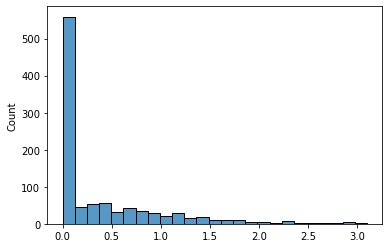

In [18]:
trunc_norm = [at.clip(x4, 0, np.inf).eval() for _ in range(1000)]
sns.histplot(np.asarray(trunc_norm))

As you can see, negative values are clipped to be 0. And you can use this, just like any other transform, directly in your model.

But there are other things you can do as well, like `stack()` RVs, and then index into them with a binary RV.

In [19]:
with pm.Model():
    x = pm.Uniform("x", lower=-1, upper=0) # only negtive
    y = pm.Uniform("y", lower=0, upper=1) # only positive
    xy = at.stack([x, y]) # combined
    index = pm.Bernoulli("index", p=0.5) # index 0 or 1
    
    indexed_RV = xy[index] # binary index into stacked variable

for _ in range(5):
    print("Sampled value = {:.2f}".format(indexed_RV.eval()))

Sampled value = 0.82
Sampled value = 0.15
Sampled value = 0.31
Sampled value = -0.71
Sampled value = 0.00


As you can see, depending on whether `index` is `0` or `1` we either sample from the negative or positive uniform. This also supports fancy indexing, so you can manually create complicated mixture distribution using a `Categorical` like this:

In [20]:
with pm.Model():
    x = pm.Uniform("x", lower=-1, upper=0)
    y = pm.Uniform("y", lower=0, upper=1)
    z = pm.Uniform("z", lower=1, upper=2)
    xyz = at.stack([x, y, z])
    index = pm.Categorical("index", [.3, .3], shape=3)
    
    index_RV = xyz[index]

for _ in range(5):
    print("Sampled value = {}".format(index_RV.eval()))

Sampled value = [ 0.79 -0.28  0.79]
Sampled value = [0.37 0.37 0.37]
Sampled value = [-0.76  0.76  0.76]
Sampled value = [ 0.91 -0.2   0.91]
Sampled value = [0.78 0.78 0.78]


## Better (and Dynamic) Shape Support

Another big improvement in `PyMC` 4.0 is in how shapes are handled internally. Before, there was also a bunch of complicated and brittle Python code to handle shapes. Internally, we had a joke where we counted how many days had passed until we had discovered a new shape bug. But no more! Now, all shape handling is completely offloaded to `aesara` which handles this properly. As a side-effect, this better shape support also allows dynamic RV shapes, where the shape depends on another RV:

In [21]:
with pm.Model() as m:
    x = pm.Poisson('x', 2)
    z = pm.Normal('z', shape=x)
    
for _ in range(5):
    print("Value of z = {}".format(z.eval()))

Value of z = [-0.54 -0.24]
Value of z = [0.33]
Value of z = [-0.22 -0.67]
Value of z = []
Value of z = [ 2.01 -0.48]


As you can see, the shape of `z` changes with each draw according to the integer sampled by `x`.

Note, however, that this does not yet work for posterior inference (i.e. sampling). The reason is that the trace backend (`arviz.InferenceData`) as well as samplers in this case also must support changing dimensionality (like reversible-jump MCMC). There are plans to add this.

## Better NUTS initialization

We have also fixed an issue with the default NUTS warm-up which sometimes lead to the sampler getting stuck for a while. While fixing this issue, [Adrian Seyboldt](https://twitter.com/aseyboldt) also came up with a new initialization method that uses the gradients to estimate a better mass-matrix. You can use this (still experimental) feature by calling `pm.sample(init="jitter+adapt_diag_grad")`.

Let's try this on the hierarchical regression model from above:

In [22]:
with model_pymc4:
    idata_pymc4_grad = pm.sample(init="jitter+adapt_diag_grad", target_accept=0.9)

The first thing to observe as that we did not get any divergences this time. Comparing the effective sample size of the default and grad-based initialization, we can also see that it leads to much better sampling for certain parameters:

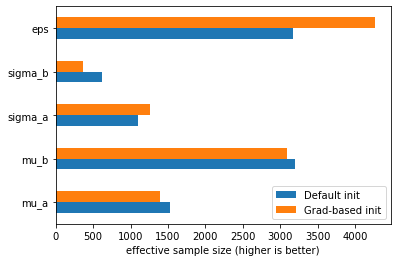

In [24]:
pd.DataFrame({"Default init": az.summary(idata_pymc4, var_names=["~a", "~b"])["ess_bulk"],
              "Grad-based init": az.summary(idata_pymc4_grad, var_names=["~a", "~b"])["ess_bulk"]}).plot.barh()
plt.xlabel("effective sample size (higher is better)");

## PyMC in the browser

Did you know that you can run PyMC in the browser now too? This is possible with [PyScript](https://www.pyscript.net). Check out [this blog post](https://www.pymc-labs.io/blog-posts/pymc-in-browser/) which has a small demo.

## Installation

Excited to try it out? Great! `conda install -c conda-forge pymc` should get you going. For detailed instructions, see [here](https://docs.pymc.io/en/latest/installation.html).

## New website

We have also completely revamped our website, you can check it out at [https://www.pymc.io](https://www.pymc.io). It's not completely done yet so expect more improvements in the future. This effort was lead by [Oriol Abril](https://oriolabrilpla.cat/).

## A Look Towards the Future

As mentioned in the beginning, `aesara` is a unique library in the PyData ecosystem as it is the only one that provides a static, mutable computation graph. Having direct access to this computation graph allows for many interesting features:
* graph optimizations like `log(exp(x)) -> x`
* symbolic rewrites like `N(0, 1) + a` -> `N(a, 1)`

and `aesara` already implements many of these. While we don't have proper benchmarks, we noticed major speed-ups of porting models from PyMC3 to 4.0, even without the JAX backend.

But these graph rewrites can become much more sophisticated. For example, [a beta prior on a binomial likelihood can be replaced with its analytical solution directly by exploiting conjugacy](https://github.com/aesara-devs/aemcmc/pull/29). 

Or a hierarchical model written in a centered parameterization can automatically be converted to its [non-centered analog](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) which often samples much more efficiently. These model reparameterizations can make a huge difference in how well a model samples. Unforutnately, these reparameterizations still require intimate knowledge of the math and a deep understanding of the posterior geometry, nothing a casual PyMC user would be familiar with. So with these graph rewrites we will be able to automatically reparameterize a PyMC model for you and find the configuration that samples most efficiently.

**In sum, we believe PyMC 4.0 is the best version yet and pushes the state of the art in probabilistic programming. But it's also stepping stone to many more innovations to come. Thanks for being a part of it.**

## Call to Action

Want to help us build the future of probabilistic programming? It's the perfect time to get involved.
If you're interested in:
* user-friendly API → [PyMC](https://github.com/pymc-devs/pymc)
* documentation and examples → [PyMC documentation](https://github.com/pymc-devs/pymc-examples)
* cutting-edge PyMC features (BART etc) → [PyMC-experimental](https://github.com/pymc-devs/pymc-experimental)
* low-level graph framework → [aesara](https://github.com/aesara-devs/aesara)
* samplers → [blackjax](https://github.com/blackjax-devs/blackjax), [aehmc](https://github.com/aesara-devs/aehmc) and [aemcmc](https://github.com/aesara-devs/aemcmc)

Also, follow us on [Twitter](https://twitter.com/pymc_devs) to stay up-to-date and join our [MeetUp group](https://www.meetup.com/pymc-online-meetup/) for upcoming events. If you're looking for consulting to solve your most challenging data science problems using PyMC, check out [PyMC Labs](https://pymc-labs.io) -- The Bayesian Consultancy.

## Accolades

While many people contributed to this effort, we would like to highlight the outstanding contributions of [Brandon Willard](https://brandonwillard.github.io), [Ricardo Vieira](https://github.com/ricardoV94), and [Kaustubh Chaudhari](https://github.com/kc611) who lead this gigantic effort.